In [ ]:
# Dataset - https://www.kaggle.com/datasets/salader/dogs-vs-cats

In [2]:
# Create the Kaggle configuration directory (if it doesn't exist)
!mkdir -p ~/.kaggle

# Copy your Kaggle API credentials (kaggle.json) to the configuration directory
!cp kaggle.json ~/.kaggle/

In [3]:
# Download the dogs vs cats dataset from Kaggle
!kaggle datasets download -d salader/dogs-vs-cats

 99% 1.05G/1.06G [00:04<00:00, 253MB/s]
100% 1.06G/1.06G [00:04<00:00, 272MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
# Import TensorFlow library (for deep learning)
import tensorflow as tf

# Import Keras, a high-level API for building deep learning models within TensorFlow
from tensorflow import keras

# From Keras, import the Sequential model class (common for stacking layers)
from keras.models import Sequential

# Import various building blocks for our model (convolutional layers, pooling, etc.)
from keras.layers import (
    Dense,  # Fully connected layers for classification
    Conv2D,  # Convolutional layers for feature extraction
    MaxPooling2D,  # Pooling layers for dimensionality reduction
    Flatten,  # Flatten layer to prepare data for fully connected layers
    BatchNormalization,  # Improves training stability
    Dropout  # Helps prevent overfitting
)


In [6]:
# Create image data generators for training and validation

# Training data generator
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/train',  # Path to your training image directory
    labels='inferred',  # Automatically infer labels from subfolders
    label_mode='int',  # Convert labels to integer format (optional)
    batch_size=32,  # Number of images processed together in each batch
    image_size=(256, 256),  # Resize images to a fixed size (256x256 pixels)
)

# Validation data generator (similar structure)
validation_ds = keras.utils.image_dataset_from_directory(
    directory='/content/test',   # Path to your validation image directory
    labels='inferred',  # Automatically infer labels from subfolders
    label_mode='int',  # Convert labels to integer format (optional)
    batch_size=32,  # Number of images processed together in each batch
    image_size=(256, 256),  # Resize images to a fixed size (256x256 pixels)
)

# Explanation:
#  - This code creates two data generators, one for training and one for validation.
#  - The `image_dataset_from_directory` function automatically reads images and labels from directories.
#  - `labels='inferred'` tells the function to infer labels based on subfolder names (assuming your images are organized by class).
#  - `label_mode='int'` (optional) converts labels to integers (useful for some models).
#  - `batch_size=32` defines the number of images processed together during training/validation.
#  - `image_size=(256, 256)` resizes all images to a fixed size for consistency.


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [7]:
# Define a function to normalize images (convert pixel values to float32 between 0 and 1)
def process(image, label):
  """
  This function normalizes the image data for better training.

  Args:
      image: A tensor representing an image.
      label: A tensor representing the image's label.

  Returns:
      A tuple containing the normalized image and the original label.
  """
  image = tf.cast(image / 255.0, tf.float32)  # Normalize pixel values between 0 and 1
  return image, label

# Apply the normalization function to each image in the training dataset
train_ds = train_ds.map(process)

# Apply the normalization function to each image in the validation dataset (use the same function)
validation_ds = validation_ds.map(process)


In [8]:
# Create a Sequential model (common for stacking layers)
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(
    filters=32,  # Number of output filters (feature maps)
    kernel_size=(3, 3),  # Size of the convolutional kernel
    padding='valid',   # Padding method (avoiding extra padding)
    activation='relu',  # Activation function (ReLU for non-linearity)
    input_shape=(256, 256, 3)  # Input shape (image size and color channels)
))
model.add(BatchNormalization())  # Normalize activations after convolution

# First Max Pooling Layer
model.add(MaxPooling2D(
    pool_size=(2, 2),  # Size of the pooling window
    strides=2,         # Stride of the pooling (skip pixels)
    padding='valid'    # Padding method (avoiding extra padding)
))

# Second Convolutional Layer with more filters
model.add(Conv2D(
    filters=64,
    kernel_size=(3, 3),
    padding='valid',
    activation='relu'
))
model.add(BatchNormalization())

# Second Max Pooling Layer
model.add(MaxPooling2D(
    pool_size=(2, 2),
    strides=2,
    padding='valid'
))

# Third Convolutional Layer with even more filters
model.add(Conv2D(
    filters=128,
    kernel_size=(3, 3),
    padding='valid',
    activation='relu'
))
model.add(BatchNormalization())

# Third Max Pooling Layer
model.add(MaxPooling2D(
    pool_size=(2, 2),
    strides=2,
    padding='valid'
))

# Flatten the data for fully-connected layers
model.add(Flatten())

# First Dense Layer (fully-connected)
model.add(Dense(
    units=128,  # Number of neurons in the layer
    activation='relu'  # Activation function (ReLU for non-linearity)
))
model.add(Dropout(0.1))  # Dropout layer to prevent overfitting (10% dropout)

# Second Dense Layer
model.add(Dense(
    units=64,
    activation='relu'
))
model.add(Dropout(0.1))  # Dropout layer (10% dropout)

# Output Layer (for binary classification)
model.add(Dense(
    units=1,  # Single output neuron
    activation='sigmoid'  # Sigmoid activation for binary output (0 or 1)
))




In [9]:
# Summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                        

In [10]:
# Configure the training process
model.compile(
    optimizer='adam',  # Optimization algorithm to adjust model weights (Adam optimizer)
    loss='binary_crossentropy',  # Loss function to measure prediction error (binary cross-entropy for binary classification)
    metrics=['accuracy']  # Metrics to monitor training progress (accuracy)
)


In [11]:
# Train the model

history = model.fit(
    train_ds,  # Training data generator
    epochs=10,  # Number of training epochs (iterations)
    validation_data=validation_ds,  # Validation data generator (for monitoring performance)
)


Epoch 1/10
625/625 [==============================] - 83s 115ms/step - loss: 1.2326 - accuracy: 0.5936 - val_loss: 0.6857 - val_accuracy: 0.6572
Epoch 2/10
625/625 [==============================] - 69s 110ms/step - loss: 0.5630 - accuracy: 0.7112 - val_loss: 0.5436 - val_accuracy: 0.7198
Epoch 3/10
625/625 [==============================] - 69s 109ms/step - loss: 0.4764 - accuracy: 0.7728 - val_loss: 0.5067 - val_accuracy: 0.7612
Epoch 4/10
625/625 [==============================] - 66s 105ms/step - loss: 0.4250 - accuracy: 0.8044 - val_loss: 0.5242 - val_accuracy: 0.7572
Epoch 5/10
625/625 [==============================] - 66s 104ms/step - loss: 0.3604 - accuracy: 0.8400 - val_loss: 0.4757 - val_accuracy: 0.7858
Epoch 6/10
625/625 [==============================] - 68s 108ms/step - loss: 0.2877 - accuracy: 0.8756 - val_loss: 0.5295 - val_accuracy: 0.7692
Epoch 7/10
625/625 [==============================] - 65s 104ms/step - loss: 0.2185 - accuracy: 0.9065 - val_loss: 0.5979 - val_ac

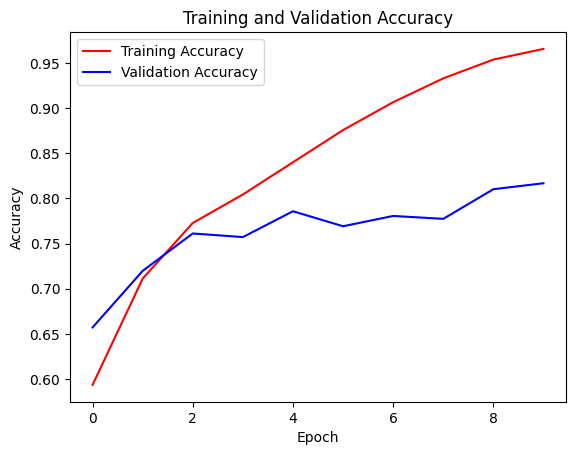

In [12]:
# Plot the training accuracy and validation accuracy

import matplotlib.pyplot as plt  # Import for plotting (assuming it's not already imported)

plt.plot(history.history['accuracy'], color='red', label='Training Accuracy')  # Plot training accuracy curve
plt.plot(history.history['val_accuracy'], color='blue', label='Validation Accuracy')  # Plot validation accuracy curve
plt.legend()  # Add a legend to distinguish the curves
plt.xlabel('Epoch')  # Label the X-axis as 'Epoch'
plt.ylabel('Accuracy')  # Label the Y-axis as 'Accuracy'
plt.title('Training and Validation Accuracy')  # Add a title to the plot
plt.show()  # Display the plot


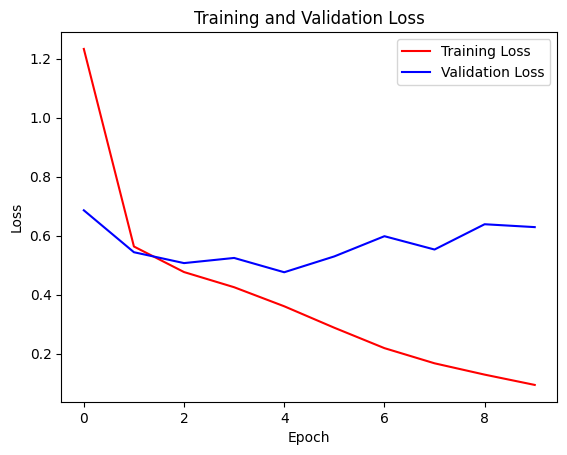

In [13]:
# Plot the training loss and validation loss

import matplotlib.pyplot as plt  # Import for plotting (assuming it's not already imported)

plt.plot(history.history['loss'], color='red', label='Training Loss')  # Plot training loss curve
plt.plot(history.history['val_loss'], color='blue', label='Validation Loss')  # Plot validation loss curve
plt.legend()  # Add a legend to distinguish the curves
plt.xlabel('Epoch')  # Label the X-axis as 'Epoch'
plt.ylabel('Loss')  # Label the Y-axis as 'Loss'
plt.title('Training and Validation Loss')  # Add a title to the plot
plt.show()  # Display the plot


In [ ]:
# ways to reduce overfitting

# Add more data
# Data Augmentation
# L1/L2 Regularizer
# Dropout
# Batch Norm
# Reduce complexity

In [14]:
import cv2

In [15]:
test_img = cv2.imread('/content/download.jpeg')

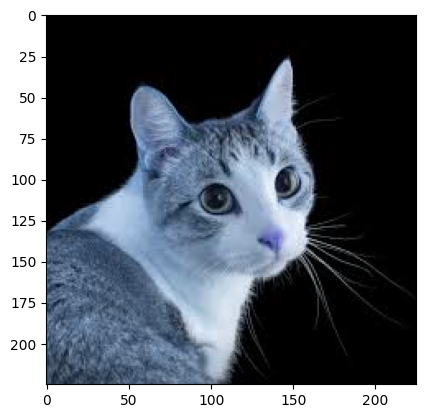

In [16]:
plt.imshow(test_img)

In [17]:
test_img.shape

(225, 225, 3)

In [18]:
test_img = cv2.resize(test_img,(256,256))

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[ 56,  71,  90],
        [ 64,  79,  98],
        [ 79,  94, 113],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 56,  71,  90],
        [ 63,  78,  97],
        [ 79,  94, 113],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 50,  64,  82],
        [ 65,  79,  97],
        [ 63,  77,  94],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]], dtype=uint8)
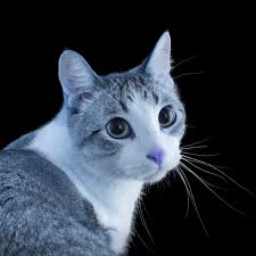

In [19]:
test_img

In [20]:
# Reshape the test image to add a batch dimension of size 1
# This is necessary for some deep learning models that expect a batch of images as input

test_input = test_img.reshape((1,256,256,3))

In [21]:
test_input

array([[[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        ...,

        [[ 56,  71,  90],
         [ 64,  79,  98],
         [ 79,  94, 113],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[ 56,  71,  90],
         [ 63,  78,  97],
         [ 79,  94, 113],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[ 50,  64,  82],
         [ 65,  79,  97],
         [ 63,  77,  94],
         ...,
         [  0,   0,   0],
        

In [22]:
model.predict(test_input)

1/1 [==============================] - 0s 410ms/step


array([[0.]], dtype=float32)